# 9.2 图像分割示例

深度学习下的图像分割是使用一个模型给图像的所有像素分配类别,从而将图像分割成多个部分.在图像视频编辑,自动驾驶,医学成像等领域有很多有价值的应用.

图像分割两种方式

- 语义分隔: 每个像素独立归到一个类别下,例如图中有两只猫,那对应的像素都会被归到"猫"的类别下.
- 实例分割: 不仅要按照类别对图像像素进行分割,还需要解析出单个物体.还是图中两只猫,实例分割不仅要把两只猫识别出来,还要把两只猫标记成 猫1 猫2.

![instance_segmentation](instance_segmentation.png)


这一节我们专注在语义分割上,尝试使得模型区分主体和背景,当然还是猫狗的数据集.


我们使用的是 Oxford-IIIT 的宠物数据集.

- 下载数据集: <https://www.robots.ox.ac.uk/~vgg/data/pets/?
- 一共有 7239 张猫狗图片.
- 常见分类问题的标签在这里是前景/背景的分割掩码.所谓分割掩码是与输入图像大小相同,但是像素只有单色通道.只有 3 种取值,对应 3 大类.
  - 1 前景
  - 2 背景
  - 3 轮廓


```shell
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
tar -xf images.tar.gz
tar -xf annotations.tar.gz
```

如果你在 linux 上运行,可以直接尝试上面的命令,最终是将数据解压到当前运行的根目录.


输入图片是都是 jpg 格式,存放在 `images/` 下.

分割遮蔽文件以同样的名称存储在 `annotations/trimaps/`.


In [1]:
import os

input_dir = "images/"  #图片路径
target_dir = "annotations/trimaps/"  #分割掩码路径

input_img_paths = sorted([
    os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")
])  #排列好的图片路径
target_paths = sorted([
    os.path.join(target_dir, fname) for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")
])  #排列好的分割掩码路径


构建两个路径


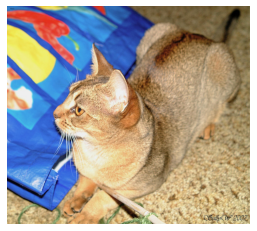

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

图片的示例


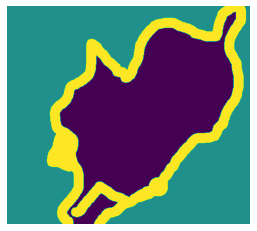

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])


img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

遮蔽文件示例


In [4]:
import numpy as np
import random

img_size = (200, 200)  #图片大小
num_imgs = len(input_img_paths)  #图片总数量

random.Random(1337).shuffle(input_img_paths)  #乱序?
random.Random(1337).shuffle(target_paths)  #乱序?


def path_to_input_image(path):  #path -> 图片内容
    return img_to_array(load_img(path, target_size=img_size))


def path_to_target(path):  #patj -> 分割掩码内容
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img


input_imgs = np.zeros((num_imgs, ) + img_size + (3, ), dtype="float32")
targets = np.zeros((num_imgs, ) + img_size + (1, ), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])  #添加图片
    targets[i] = path_to_target(target_paths[i])  #添加分割掩码

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]  #训练集 取后1000个以外
train_targets = targets[:-num_val_samples]  #训练集 取后1000个以外
val_input_imgs = input_imgs[-num_val_samples:]  #验证集 取后1000个
val_targets = targets[-num_val_samples:]  #验证集 取后1000个


训练和测试数据集,全部乱序后取.


In [8]:
print(train_input_imgs.shape)
print(val_input_imgs.shape)

(6390, 200, 200, 3)
(1000, 200, 200, 3)


训练集是 6390 测试集是 1000


In [6]:
from tensorflow import keras
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))
    x = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)  #转换数据

    x = layers.Conv2D(64, 3, strides=2, activation="relu",
                      padding="same")(x)  #步长2 填充,相当于下采样 尺寸x0.5
    x = layers.Conv2D(64, 3, activation="relu",
                      padding="same")(x)  #步长2#步长1 填充 图片尺寸不变
    x = layers.Conv2D(128, 3, strides=2, activation="relu",
                      padding="same")(x)  #步长2 填充,相当于下采样 尺寸x0.5
    x = layers.Conv2D(128, 3, activation="relu",
                      padding="same")(x)  #步长1 填充 图片尺寸不变
    x = layers.Conv2D(256, 3, strides=2, padding="same",
                      activation="relu")(x)  #步长2 填充,相当于下采样 尺寸x0.5
    x = layers.Conv2D(256, 3, activation="relu",
                      padding="same")(x)  #步长1 填充 图片尺寸不变

    x = layers.Conv2DTranspose(256, 3, activation="relu",
                               padding="same")(x)  #步长1 填充 图片尺寸不变
    x = layers.Conv2DTranspose(256,
                               3,
                               activation="relu",
                               padding="same",
                               strides=2)(x)  #步长2 填充,相当于上采样 尺寸x2
    x = layers.Conv2DTranspose(128, 3, activation="relu",
                               padding="same")(x)  #步长1 填充 图片尺寸不变
    x = layers.Conv2DTranspose(128,
                               3,
                               activation="relu",
                               padding="same",
                               strides=2)(x)  #步长2 填充,相当于上采样 尺寸x2
    x = layers.Conv2DTranspose(64, 3, activation="relu",
                               padding="same")(x)  #步长1 填充 图片尺寸不变
    x = layers.Conv2DTranspose(64,
                               3,
                               activation="relu",
                               padding="same",
                               strides=2)(x)  #步长2 填充,相当于上采样 尺寸x2

    outputs = layers.Conv2D(3,
                            num_classes,
                            activation="softmax",
                            padding="same")(x)  #最后的卷积层 填充,尺寸不变

    model = keras.Model(inputs, outputs)
    return model


model = get_model(img_size=img_size, num_classes=3)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 25, 256)       2951

模型主要有两大部分,前半部分的 Conv2D 后半部分的Conv2DTranspose

前半部分与前文的例子相同,相当于一个对图片宽高压缩,深度轴不断加深.

- Conv2D x6
- 3 次步长 =2 的下采样
- (200,200,3) -> (100,100,64) -> (50,50,128) -> (25,25,256)

与第八章的例子不同,这里的下采样是使用步长2.而不是最大池化.

- 最大池化在分类表现优异,尽量保留高增益的特征信息.但是却破坏了信息的空间位置.
- 我们这里是图片分割问题,异常关心信息的空间位置,使用最大池化会破坏信息的空间位置.而步长2的下采样会尽量保留信息的空间位置.
- 不止这里,以后的例子本书都会倾向于选择步长的下采样,而不是最大池化.

后半部分是 Conv2DTranspose 的堆叠.相当于是从 (25,25,256) 不断反卷积,恢复到 (200,200,3),将信息从深度轴不断展开.

- Conv2DTranspose 是反卷积,可以看作是一种上采样.
- Conv2DTranspose x6
- 3 次步长 2 的上采样.
- (25,25,256) -> (50,50,256) -> (50,50,128) -> (100,100,128) -> (100,100,64) ->(200,200,64)

最后的卷积层 (200,200,64) -> (200,200,3)


In [10]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "oxford_segmentation.keras",  #模型保存路径
        save_best_only=True)  #保存最好的模型
]

In [12]:
history = model.fit(
    train_input_imgs,
    train_targets,
    epochs=50,  #训练50个epoch
    callbacks=callbacks,
    batch_size=32,  #每次训练32张图片 64 会导致显存不足
    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
200/200 [==============================] - 56s 262ms/step - loss: 3.3382 - val_loss: 0.8599
Epoch 2/50
200/200 [==============================] - 49s 245ms/step - loss: 0.8243 - val_loss: 0.7687
Epoch 3/50
200/200 [==============================] - 49s 247ms/step - loss: 0.7476 - val_loss: 0.6994
Epoch 4/50
200/200 [==============================] - 49s 247ms/step - loss: 0.6777 - val_loss: 0.6962
Epoch 5/50
200/200 [==============================] - 49s 247ms/step - loss: 0.6217 - val_loss: 0.5518
Epoch 6/50
200/200 [==============================] - 49s 247ms/step - loss: 0.5751 - val_loss: 0.6167
Epoch 7/50
200/200 [==============================] - 49s 247ms/step - loss: 0.5497 - val_loss: 0.5018
Epoch 8/50
200/200 [==============================] - 49s 247ms/step - loss: 0.5159 - val_loss: 0.5829
Epoch 9/50
200/200 [==============================] - 49s 247ms/step - loss: 0.4892 - val_loss: 0.6148
Epoch 10/50
200/200 [==============================] - 49s 247ms/step - l

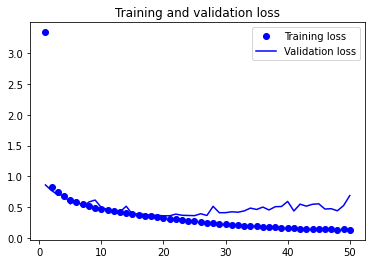

In [13]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

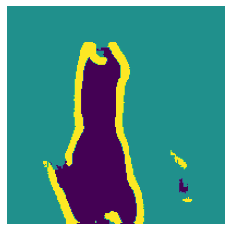

In [14]:
from tensorflow.keras.preprocessing.image import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]


def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)


display_mask(mask)